In [1]:
version_num = "17"

In [2]:
import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline 
# For putting audio in the notebook
import IPython.display
import pypianoroll
from music_theory_utils import make_dicts,inversion
from gen_music import *
import datetime
import config
import copy
import itertools
import os
import shutil

### ここから★

In [3]:
pentas_choice = ['C4', 'D4', 'E4', 'G4', 'A4', 'C5', 'D5']
pentas_choice = {key:1/len(pentas_choice) for key in pentas_choice}

In [4]:
list_note_dulation = np.array(list(config.dulation_char2num_dicts.values()))
list_char = config.dulation_char2num_dicts.keys()

In [5]:
note_max_count = [np.arange(int(1+96/i) ) for i in list_note_dulation ]
note_count_candi = itertools.product( *note_max_count )

In [6]:
pattern_list = []
for note_count in note_count_candi:
    dulation_sum = np.dot(list_note_dulation, note_count)
    if dulation_sum == 96:
        pattern_list.append(note_count)

In [7]:
dulation_prob = {
    "bar":1,"half":1,
    "quarter":1,"dotted_quarter":1,
    "quaver":1}#,  "dotted_quaver":1,
    #"quarter_tri":0 ,"quaver_tri":0,
    #"semiquaver":0.8}

In [8]:

list_char = [[i] for i in list_char]

note_prob = list( dulation_prob.values() )
#['bar','half','quarter','quaver','quarter_tri','quaver_tri','semiquaver']

motif_pattern_list_text = []
motif_prob_list = []

for pattern in pattern_list:
    synth_char = []
    motif_prob = 1
    
    for num, note_count in enumerate(pattern):
        synth_char += list_char[num] * note_count
        motif_prob *= note_prob[num] ** note_count 
        
    motif_pattern_list_text.append(synth_char)
    motif_prob_list.append(motif_prob)
    
motif_prob_list = motif_prob_list/np.sum( motif_prob_list ) 
#正規化

In [9]:
#音符
class Note:
    def __init__(self,dulation_char,onoff_char,pitch_char="C-2",bpm=120):
        self.dulation_char  = dulation_char # quaver, (長さ) "quaver"
        self.onoff_char     = onoff_char # on or off 
        self.pitch_char     = pitch_char #'C5'
        self.bpm       = bpm
        self.char2num()
        
    def char2num(self): ##charの状態をnumに反映させる
        self.dulation_num  = config.dulation_char2num_dicts[self.dulation_char]
        self.onoff_num     = 1 if (self.onoff_char == "on") else 0
        self.pitch_num     = config.pitch_char2num_dicts[self.pitch_char]

    def num2char(self): ##numの状態をcharに反映させる
        self.dulation_char = config.dulation_num2char_dicts[self.dulation_num]
        self.onoff_char    = "on" if (self.onoff_num == 1) else "off"
        self.pitch_char    = config.pitch_num2char_dicts[self.pitch_num]
    
    
    def change_pitch(self,pentas_choice):        
        if self.onoff_char == "on":
            pitch_char = np.random.choice(list(pentas_choice.keys()),p=list(pentas_choice.values()),replace=True)
            self.pitch_char = pitch_char
        self.char2num()
                
class Bar:
    def __init__(self,beat=4):
        self.beat     = beat
        self.bar_reso = int( config.bar_reso * (self.beat/4) )
        self.notes    = []
        
    def append(self,note):
        self.notes.append(note)
    
class Motif: 
    def __init__(self,beat,bar_num):
        self.notes   = []
        self.beat     = beat
        self.bar_num  = bar_num #モチーフの小節数。
        
        self.bar_reso    = int( config.bar_reso * (self.beat/4) )
        self.motif_reso  = self.bar_reso * self.bar_num
        self.make_motif()
        
    def make_motif(self):#1小節リズム生成 
        motif_combination = np.random.choice(motif_pattern_list_text,p= motif_prob_list )
        np.random.shuffle( motif_combination )
        for note_char in motif_combination:
            onoff_char = np.random.choice(["on","off"], p=[0.9,0.1])
            note = Note(note_char,onoff_char,"C-2")
            note.change_pitch(pentas_choice = pentas_choice)
            self.notes.append(note)
            
        return self.notes
    
    def print_motif(self):
        for note in self.notes:
            print(note.dulation_char,note.pitch_char,note.onoff_char)
        
class Phrase: 
    def __init__(self,base_motif,part_name="Amelo",motif_patern="ABACABACABACABAC"):
        
        # 基本となるモチーフ
        self.base_motif   = base_motif 
        # Amelo,Bmelo,Sabi,etc..
        self.part_name     = part_name   
        self.motif_patern = motif_patern
        #phraseに含まれる小節数
        self.bar_num       = len(self.motif_patern) * self.base_motif.bar_num
        ##motifインスタンスのリスト
        self.motifs        = []
        
        self.motif_dict = self.make_motif_dict() 
        
        for patern in self.motif_patern:
            self.motifs.append( self.motif_dict[patern] )
            
    def make_motif_dict(self):
        unique_paterns = set(self.motif_patern)            
        motif_dict    = {}

        for patern in unique_paterns:
            motif_cp = copy.deepcopy(self.base_motif)
            
            if patern  == "A": #そのままコピー
                pass

            elif patern == "B": #リズムをキープしてピッチをふりなおす
                for note in motif_cp.notes:
                    note.change_pitch(pentas_choice=pentas_choice)

            elif patern == "C":  #完全新規
                motif_cp = Motif(beat=motif_cp.beat,bar_num=motif_cp.bar_num)
                
            motif_dict[patern] = motif_cp

        return motif_dict
    
    def print_phrase(self):
        for motief in self.motifs:
            print("---")
            motief.print_motif()

In [10]:
base_motif  = Motif(beat=4,bar_num=1)
base_phrase = Phrase(base_motif=base_motif,part_name="Amelo",motif_patern="AABCAABC")
lyric       = [i for i in "それってあなたのかんそうですよね"]
len_lyric   = len(lyric)

C:\Users\ryo\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


notes2musicxml

In [11]:
import music21 as m2
import pickle as pkl
from config import *

In [12]:
# ストリーム全体に関わる設定：楽器名とか調とか
mystrm = m2.stream.Part()
# 楽器
myinst = m2.instrument.Instrument()
myinst.partName = "Kiritan"
mystrm.append(myinst)
# 調号
mystrm.append(m2.key.Key('c', 'major'))
# 音部記号
mystrm.append(m2.clef.TrebleClef())
# mystrm.append(m2.clef.BassClef()) へ音記号

In [13]:
ind_lyric  = 0
pitch_bias = -12
for motif in base_phrase.motifs: # 8小節
    cur_measure = m2.stream.Measure() 
    cur_measure.append( m2.tempo.MetronomeMark(number=motif.notes[0].bpm) ) 
    for note in motif.notes:
        quater_length = note.dulation_num/24
        print(note.dulation_char,note.pitch_char,note.onoff_char)
        print(note.dulation_num,note.pitch_num,note.onoff_num)

        if note.onoff_char == "on":
            note_number = note.pitch_num + pitch_bias
            char = lyric[ind_lyric%len_lyric]
            ind_lyric += 1
            n = m2.note.Note(note_number, quarterLength=quater_length, lyric=char)

        else:# 休符
            n = m2.note.Rest(quarterLength=quater_length)
            # 音符を放り込んだ小節をストリームに放り込む
        cur_measure.append(n)
    mystrm.append(cur_measure)

quarter A4 on
24 81 1
quarter E4 on
24 76 1
dotted_quarter C4 on
36 72 1
quaver D5 on
12 86 1
quarter A4 on
24 81 1
quarter E4 on
24 76 1
dotted_quarter C4 on
36 72 1
quaver D5 on
12 86 1
quarter E4 on
24 76 1
quarter A4 on
24 81 1
dotted_quarter C5 on
36 84 1
quaver C5 on
12 84 1
quaver C5 on
12 84 1
quaver D4 on
12 74 1
dotted_quarter C4 on
36 72 1
dotted_quarter G4 on
36 79 1
quarter A4 on
24 81 1
quarter E4 on
24 76 1
dotted_quarter C4 on
36 72 1
quaver D5 on
12 86 1
quarter A4 on
24 81 1
quarter E4 on
24 76 1
dotted_quarter C4 on
36 72 1
quaver D5 on
12 86 1
quarter E4 on
24 76 1
quarter A4 on
24 81 1
dotted_quarter C5 on
36 84 1
quaver C5 on
12 84 1
quaver C5 on
12 84 1
quaver D4 on
12 74 1
dotted_quarter C4 on
36 72 1
dotted_quarter G4 on
36 79 1


In [14]:
neutrino_file_store = "C:/Users/ryo/Documents/Git/ai-music/neutrino_file_store"
neutrino_input_musicxml = "C:/Users/ryo/Documents/AI/NEUTRINO-Windows_v0.510/NEUTRINO/score/musicxml/test.musicxml"
neutrino_output_wav = "C:/Users/ryo/Documents/AI/NEUTRINO-Windows_v0.510/NEUTRINO/output/test_syn.wav"

mystrm.write(fp=neutrino_input_musicxml)

WindowsPath('C:/Users/ryo/Documents/AI/NEUTRINO-Windows_v0.510/NEUTRINO/score/musicxml/test.musicxml')

In [15]:
import subprocess

cmd = "C:/Users/ryo/Documents/AI/NEUTRINO-Windows_v0.510/NEUTRINO/Run.bat"
returncode = subprocess.call(cmd, shell=True)

In [16]:
dt_now = datetime.datetime.now()

if os.path.exists(neutrino_input_musicxml):
    copy_musicxml = neutrino_file_store + f'/{version_num}_{dt_now.year:04d}{dt_now.month:02d}{dt_now.day:02d}_{dt_now.hour:02d}{dt_now.minute:02d}{dt_now.second:02d}.musicxml'
    shutil.copyfile(neutrino_input_musicxml, copy_musicxml)
else:
    print("musicxmlファイルのコピーに失敗しました")

if os.path.exists(neutrino_output_wav):
    copy_wav = neutrino_file_store + f'/{version_num}_{dt_now.year:04d}{dt_now.month:02d}{dt_now.day:02d}_{dt_now.hour:02d}{dt_now.minute:02d}{dt_now.second:02d}.wav'
    shutil.copyfile(neutrino_output_wav, copy_wav)
else:
    print("wavファイルのコピーに失敗しました")


In [35]:
class ItsuUta():
    def __init__(self):
        self.parts = []
        
    def make_song():
        
        make_motief_rhythm():
            
    #motiefをbarに移し替えたい。歌詞入れたり、
    def motief2bar():
    
    
    def export_musicxml():
    #歌詞と音符からmusicxmlに吐き出す。

SyntaxError: invalid syntax (Temp/ipykernel_11476/85250177.py, line 7)

In [34]:
test = ItsuUta()

In [36]:
bar = test.make_motief_rhythm(beat=4)

<class 'int'>


In [43]:
bar.notes[0].dulation_char

'quaver'

In [ ]:
    
class Motif: 
    def __init__(self,beat,bar_num):
        self.notes   = []
        self.beat     = beat
        self.bar_num  = bar_num #モチーフの小節数。
        
        self.bar_reso    = int( config.bar_reso * (self.beat/4) )
        self.motif_reso  = self.bar_reso * self.bar_num
        
        self.make_motif()
        
    def note_dulation_gen(self): #音符一個適当に返す。
        note_choice = [Note("quarter","on","C-2"),Note("quaver","on","C-2"),Note("quarter","off","C-2"),Note("quaver","off","C-2")]
        note_prob   = [0.6,0.3,0.05,0.05]
        note = np.random.choice(note_choice ,p=note_prob,replace=True)
        return note
    
    def make_motif(self):#1小節リズム生成 
        #bar_num : 0.5,1, 2, 4, 8   
        # 0.5 => 1/2小節
        note_dulation_sum= 0
        
        while (self.motif_reso) > note_dulation_sum:
            
            note = self.note_dulation_gen()
            self.notes.append(note)
            note_dulation_sum += note.dulation_num
            ## quater,quater,quater,quaver,quater 
            if note_dulation_sum > self.motif_reso: #1小節を超えたら
                diff_dulation     = note_dulation_sum - self.motif_reso #quaver
                note.dulation_num = diff_dulation
                note.num2char()
                
            note.change_pitch(pentas_choice = pentas_choice)
            
        return self.notes
    
    def print_motif(self):
        for note in self.notes:
            print(note.dulation_char,note.pitch_char,note.onoff_char)

In [11]:
bar_rhythm_list

[['quaver_note',
  'quarter_note',
  'quarter_note',
  'quarter_note',
  'quaver_note'],
 ['quaver_note',
  'quarter_note',
  'quarter_note',
  'quarter_note',
  'quaver_note'],
 ['quaver_note',
  'quarter_note',
  'quarter_note',
  'quarter_note',
  'quaver_note']]

In [12]:
bar_pitch_list

[['C5', 'G5', 'C4', 'A5', 'C4'],
 ['D4', 'A5', 'D5', 'A4', 'E4'],
 ['E5', 'A5', 'A5', 'A5', 'A4']]

In [4]:
multitrack   = pypianoroll.Multitrack(resolution=quarter_reso,tempo=tempos)

### make chord track

In [5]:
track1 = pypianoroll.StandardTrack(name="piano",program=0,is_drum=False)
multitrack.tracks.append(track1)

In [6]:
bar_backing_rhythm_list = []
bar_backing_chord_list = []
bar_backing_pianoroll_list = []

bar_backing_rhythm_list.append( make_backing_rhythm() )
bar_backing_chord_list.append( make_backing_chord() )

pianoroll = chord2pianorll(bar_backing_rhythm_list[0],bar_backing_chord_list[0])
bar_backing_pianoroll_list.append( pianoroll )

In [7]:
backing_pianorll = np.array(bar_backing_pianoroll_list)
backing_pianorll = backing_pianorll.reshape(-1,pitch_reso)

In [8]:
track1.pianoroll = backing_pianorll

[<AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>]

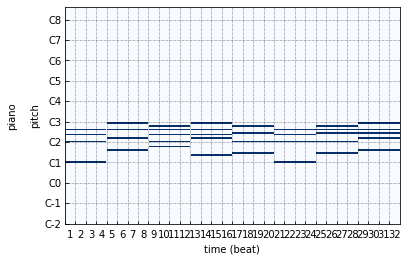

In [9]:
#plt.figure()
multitrack.plot()

### モチーフ反復

In [10]:
bar_rhythm_list = []
bar_pitch_list = []
bar_pianoroll_list = []
bar_rhythm_list.append(make_motief_rhythm())
bar_pitch_list.append(make_motief_pitch(bar_rhythm_list[0]))
bar_pianoroll_list.append(events2pianoroll(bar_rhythm_list[0], bar_pitch_list[0]))

for i in [1, 2]:
    if np.random.choice([0, 1], p=[0.5, 0.5]):
        print("コピー")
        # モチーフ反復
        bar_rhythm_list.append(bar_rhythm_list[0])
        bar_pitch_list.append(bar_pitch_list[0])
        bar_pianoroll_list.append(bar_pianoroll_list[0])
    else:
        print("振りなおし")
        # ピッチを振りなおす
        bar_rhythm_list.append(bar_rhythm_list[0])
        bar_pitch_list.append(make_motief_pitch(bar_rhythm_list[0]))
        bar_pianoroll_list.append(events2pianoroll(bar_rhythm_list[i], bar_pitch_list[i]))


振りなおし
振りなおし


In [10]:
verse_pre = np.array(bar_pianoroll_list)

In [11]:
verse_break_rhythm, verse_break_pitch, verse_break = make_motief()
bar_pitch_list.append(verse_break_pitch)
bar_rhythm_list.append(verse_break_rhythm)
verse = np.concatenate([verse_pre, verse_break.reshape(1, bar_reso, pitch_reso)], axis = 0).reshape(4*bar_reso, pitch_reso)

In [12]:
pianoroll = np.tile(verse,(2,1))
track2 = pypianoroll.StandardTrack(name="piano",program=12,is_drum=False)

In [13]:
multitrack.tracks.append(track2)
track2.pianoroll = pianoroll

[<AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>,
 <AxesSubplot:xlabel='time (beat)', ylabel='piano\n\npitch'>]

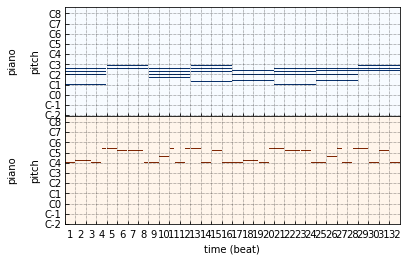

In [14]:
multitrack.plot()

In [15]:
pm = multitrack.to_pretty_midi()

In [16]:
dt_now = datetime.datetime.now()
pm.write(f'midi/{version_num}_{dt_now.year:04d}{dt_now.month:02d}{dt_now.day:02d}_{dt_now.hour:02d}{dt_now.minute:02d}{dt_now.second:02d}.midi')

### 隔離

In [17]:
import pickle as pkl
with open("save/part2_for_musixxml.pkl","wb") as f:
    pkl.dump([bar_rhythm_list,bar_pitch_list],f)

In [18]:
bar_rhythm_list

[['quarter_note',
  'quarter_note',
  'quaver_note',
  'quarter_note',
  'quaver_note'],
 ['quarter_note',
  'quarter_note',
  'quaver_note',
  'quarter_note',
  'quaver_note'],
 ['quarter_note',
  'quarter_note',
  'quaver_note',
  'quarter_note',
  'quaver_note'],
 ['quarter_note', 'quarter_note', 'quarter_note', 'quarter_note']]

In [19]:
bar_pitch_list

[['C4', 'D4', 'D4', 'C4', 'E5'],
 ['E5', 'D5', 'D5', 'D5', 'C4'],
 ['C4', 'G4', 'E5', 'C4', 'E5'],
 ['E5', 'C4', 'D5', 'C4']]

In [ ]:
#IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)